In [1791]:
import pandas as pd
import tueplots as tue 
from tueplots import bundles, figsizes
from tueplots.constants.color import rgb
from tueplots.constants.color import palettes
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tueplots.constants import markers as marker_constants
import numpy as np
import joypy
import warnings
import concurrent.futures

## src functions

In [1331]:
# Merge all dataframes and rename the count columns
def rename_merge(dataframes, suffixes):
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].copy()

        for column in dataframes[i].columns:
            if(column == 'frame.time'):
                continue
            dataframes[i].rename(columns={column: f'{column}_{suffixes[i]}'}, inplace=True)

    merge_df = dataframes[0]

    for dataframe in dataframes[1:]:
        merge_df = merge_df.merge(dataframe, how='outer', on='frame.time')

    return merge_df.dropna()

def rename_all_columns_merge(dataframes, suffixes):

    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].copy()
        dataframes[i].columns = [f'{col}_{suffixes[i]}' for col in dataframes[i].columns]

    merge_df = dataframes[0]

    for dataframe in dataframes[1:]:
        merge_df = merge_df.merge(dataframe, how='outer', on=f'frame.time_{suffixes[i]}')

    return merge_df.dropna()

In [1276]:
#  only keeps the time of data frames
def keepOnlyTime(data):
    data = data.copy()
    data['frame.time'] = data['frame.time'].dt.time.astype(str)
    data["frame.time"] = data["frame.time"].str.replace(r':\d{2}$', '', regex=True)

    return data

In [1522]:
def random_counts(enter_count):
   r = np.random.uniform(0, 1, enter_count)
   r_c = np.ones_like(r)
   r_c = np.where(r >= 0.85, np.where(r >= 0.90, 0, 2 ), 1)
   return r_c.sum()

In [1286]:
def getcumSumMerged(data) :

    data = data.copy()
    data['count_CumSum'] = data['count_First'].cumsum() - data['count_Last'].cumsum()

    return data


In [1222]:
def getCumSum(dataFirst, dataLast):
    data = dataLast.copy()
    data['count'] = dataFirst['count'].cumsum() - dataLast['count'].cumsum()

    return data

In [1158]:
def ResampleToXTime(periode, data):

    # Set 'time' column as index
    # data.set_index('frame.time', inplace=True)

    # Resample and sum up 'count' every x minutes
    resampled_data = data.resample(periode + 'Min').sum()

    # # Reset index
    resampled_data.reset_index(inplace=True)

    return resampled_data

In [ ]:
#  only keeps the time of data frames
def keepOnlyTime(data):
    data = data.copy()
    data['frame.time'] = data['frame.time'].dt.time.astype(str)
    data["frame.time"] = data["frame.time"].str.replace(r':\d{2}$', '', regex=True)

    return data

In [1043]:
# To suppress all warnings
warnings.filterwarnings("ignore")

```python
    # example of set plot stylesheet 
    plt.rcParams.update(bundles.icml2023(column='full', nrows=1, ncols=2, usetex=False))

    plt.savefig('figname_cml.pdf')

``````

# load data as csv files

In [1064]:
onedrive_path = r"/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner"
dMonday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/080124Monday.csv')
print("Monday loaded")
dTuesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/090124Tuesday.csv')
print("Tuesday loaded")
dWednesday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/100124Wednesday.csv')
print("Wednesday loaded")
dThursday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/110124Thursday.csv')
print("Thursday loaded")
dFriday = pd.read_csv(onedrive_path + r'/Data_literacy_mensa/Mensa_data_time_formated/120124Friday.csv')
print("Friday loaded")

Monday loaded
Tuesday loaded
Wednesday loaded
Thursday loaded
Friday loaded


## Change data types and reasure right loaded csv

In [1067]:
def changeDataTypes(data, day):

    try: 
        data['frame.time'] = pd.to_datetime(data['frame.time'], format='ISO8601')
        data = data.drop('Unnamed: 0', axis=1)
        data = data.reset_index(drop=True)
    except Exception as e:
        print(f"There was the exception: {e} in {day}")
    
    print(f"{day} time processed")

    return data

In [1068]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    dMonday_future = executor.submit(changeDataTypes, dMonday, "Monday")
    dTuesday_future = executor.submit(changeDataTypes, dTuesday, "Tuesday")
    dWednesday_future = executor.submit(changeDataTypes, dWednesday, "Wednesday")
    dThursday_future = executor.submit(changeDataTypes, dThursday, "Thursday")
    dFriday_future = executor.submit(changeDataTypes, dFriday, "Friday")

dMonday = dMonday_future.result()
dTuesday = dTuesday_future.result()
dWednesday = dWednesday_future.result()
dThursday = dThursday_future.result()
dFriday = dFriday_future.result()

Tuesday time processed
Friday time processed
Thursday time processed
Monday time processed
Wednesday time processed


# filter data to keep only requested data

In [1153]:
# filter for devices that comunicate with an cisco router
def filter(data):
    # data = data.copy()
    eduroam_ssid = '656475726f616d'

    # The ^ tell the regular expression, that it start with the pattern that follows
    cisco_pattern = '^' + '00:f6:63:'

    d_dpa = data.loc[data['_ws.col.protocol'] == 'EAP']

    # Authentication with all cisco devices
    df_dpa_cisco = d_dpa.loc[d_dpa['wlan.sa'].str.match(cisco_pattern)]

    # Authenticated mac addresses as a list
    dpa_cisco_list = df_dpa_cisco['wlan.da'].unique().tolist()

    # All data filterd for eduroam, UTGuest and Guest
    # df = data.loc[(data["wlan.ssid"] == eduroam_ssid)]
    df = data.loc[(data["wlan.ssid"] == eduroam_ssid)|(data["wlan.ssid"] == "55546775657374" )|( data["wlan.ssid"] =="4775657374")]

    # all unique mac addresses with the ssids
    all_sources = df["wlan.sa"].unique().tolist()

    # Combination of mac addresses of the ssids and EPA
    # combined_macs = list(set(all_sources + dpa_cisco_list))
    combined_macs = list(set(all_sources))

    # Check filter 
    diff_elements = [x for x in all_sources if x not in dpa_cisco_list]
    
    print("\n")
    print(f"Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco['wlan.da'].nunique()}")
    print(f"Number of unqiue mac addresses verfied by ssid: {len(all_sources)}")
    print(f"Number of elemtents in ssid without cisco {len(diff_elements)}")
    print(f"Number of elemtents in ssid combined with cisco {len(combined_macs)}")


    # Drop NaNs and sort for time
    data.dropna(subset=['wlan.sa'], inplace = True)
    data['wlan.ssid'].value_counts().sort_index(inplace=True)


    # All entries that use the resulting mac addresses
    return data.loc[data['wlan.sa'].isin(combined_macs)]

In [1154]:
# use filter method
dFilteredMonday = filter(dMonday)
dFilteredTuesday  = filter(dTuesday)
dFilteredWednesday  = filter(dWednesday)
dFilteredThursday  = filter(dThursday)
dFilteredFriday  = filter(dFriday)



Number of unqiue mac addresses verfied by cisco: 995
Number of unqiue mac addresses verfied by ssid: 1716
Number of elemtents in ssid without cisco 735
Number of elemtents in ssid combined with cisco 1716


Number of unqiue mac addresses verfied by cisco: 329
Number of unqiue mac addresses verfied by ssid: 3565
Number of elemtents in ssid without cisco 3320
Number of elemtents in ssid combined with cisco 3565


Number of unqiue mac addresses verfied by cisco: 1189
Number of unqiue mac addresses verfied by ssid: 1914
Number of elemtents in ssid without cisco 754
Number of elemtents in ssid combined with cisco 1914


Number of unqiue mac addresses verfied by cisco: 757
Number of unqiue mac addresses verfied by ssid: 2047
Number of elemtents in ssid without cisco 1298
Number of elemtents in ssid combined with cisco 2047


Number of unqiue mac addresses verfied by cisco: 413
Number of unqiue mac addresses verfied by ssid: 2763
Number of elemtents in ssid without cisco 2452
Number of elem

# Create Dataframe first and last seen

In [1627]:
dFirstMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()

# Count Dataframe

In [1628]:
dCountFirstMonday = pd.DataFrame(dFirstMonday['frame.time'].value_counts().sort_index())
dCountLastMonday = pd.DataFrame(dLastMonday['frame.time'].value_counts().sort_index())
dCountFirstTuesday = pd.DataFrame(dFirstTuesday['frame.time'].value_counts().sort_index())
dCountLastTuesday = pd.DataFrame(dLastTuesday['frame.time'].value_counts().sort_index())
dCountFirstWednesday = pd.DataFrame(dFirstWednesday['frame.time'].value_counts().sort_index())
dCountLastWednesday = pd.DataFrame(dLastWednesday['frame.time'].value_counts().sort_index())
dCountFirstThursday = pd.DataFrame(dFirstThursday['frame.time'].value_counts().sort_index())
dCountLastThursday = pd.DataFrame(dLastThursday['frame.time'].value_counts().sort_index())
dCountFirstFriday = pd.DataFrame(dFirstFriday['frame.time'].value_counts().sort_index())
dCountLastFriday = pd.DataFrame(dLastFriday['frame.time'].value_counts().sort_index())

# Resample for every time

In [1629]:
d1CountFirstMonday = ResampleToXTime('1',dCountFirstMonday)
d1CountFirstTuesday = ResampleToXTime('1',dCountFirstTuesday)
d1CountFirstWednesday = ResampleToXTime('1',dCountFirstWednesday)
d1CountFirstThursday = ResampleToXTime('1',dCountFirstThursday)
d1CountFirstFriday = ResampleToXTime('1',dCountFirstFriday)

d1CountLastMonday = ResampleToXTime('1',dCountLastMonday)
d1CountLastTuesday = ResampleToXTime('1',dCountLastTuesday)
d1CountLastWednesday = ResampleToXTime('1',dCountLastWednesday)
d1CountLastThursday = ResampleToXTime('1',dCountLastThursday)
d1CountLastFriday = ResampleToXTime('1',dCountLastFriday)

In [1630]:
d5CountFirstMonday = ResampleToXTime('5', dCountFirstMonday)
d5CountLastMonday = ResampleToXTime('5', dCountLastMonday)
d5CountFirstTuesday = ResampleToXTime('5', dCountFirstTuesday)
d5CountLastTuesday = ResampleToXTime('5', dCountLastTuesday)
d5CountFirstWednesday = ResampleToXTime('5', dCountFirstWednesday)
d5CountLastWednesday = ResampleToXTime('5', dCountLastWednesday)
d5CountFirstThursday = ResampleToXTime('5', dCountFirstThursday)
d5CountLastThursday = ResampleToXTime('5', dCountLastThursday)
d5CountFirstFriday = ResampleToXTime('5', dCountFirstFriday)
d5CountLastFriday = ResampleToXTime('5', dCountLastFriday)

# Merge Last  & First

In [1631]:
d1FirstLastMonday = rename_merge([d1CountFirstMonday, d1CountLastMonday], ['First', 'Last'])
d1FirstLastTuesday = rename_merge([d1CountFirstTuesday, d1CountLastTuesday], ['First', 'Last'])
d1FirstLastWednesday = rename_merge([d1CountFirstWednesday, d1CountLastWednesday], ['First', 'Last'])
d1FirstLastThursday = rename_merge([d1CountFirstThursday, d1CountLastThursday], ['First', 'Last'])
d1FirstLastFriday = rename_merge([d1CountFirstFriday, d1CountLastFriday], ['First', 'Last'])

In [1632]:
d5FirstLastMonday = rename_merge([d5CountFirstMonday, d5CountLastMonday], ['First', 'Last'])
d5FirstLastTuesday = rename_merge([d5CountFirstTuesday, d5CountLastTuesday], ['First', 'Last'])
d5FirstLastWednesday = rename_merge([d5CountFirstWednesday, d5CountLastWednesday], ['First', 'Last'])
d5FirstLastThursday = rename_merge([d5CountFirstThursday, d5CountLastThursday], ['First', 'Last'])
d5FirstLastFriday = rename_merge([d5CountFirstFriday, d5CountLastFriday], ['First', 'Last'])

# Cumlative Sum

In [1633]:
d5FirstLastCumSumMonday =  getcumSumMerged(d5FirstLastMonday)
d5FirstLastCumSumTuesday =  getcumSumMerged(d5FirstLastTuesday)
d5FirstLastCumSumWednesday =  getcumSumMerged(d5FirstLastWednesday)
d5FirstLastCumSumThursday =  getcumSumMerged(d5FirstLastThursday)
d5FirstLastCumSumFriday =  getcumSumMerged(d5FirstLastFriday)

In [1634]:
d1FirstLastCumSumMonday =  getcumSumMerged(d1FirstLastMonday)
d1FirstLastCumSumTuesday =  getcumSumMerged(d1FirstLastTuesday)
d1FirstLastCumSumWednesday =  getcumSumMerged(d1FirstLastWednesday)
d1FirstLastCumSumThursday =  getcumSumMerged(d1FirstLastThursday)
d1FirstLastCumSumFriday =  getcumSumMerged(d1FirstLastFriday)

# Correct data

In [1713]:
def correctData(data):

    cData = data.copy()

    if(cData['count_CumSum'].min() < 0) :
        cData['count_CumSum'] = cData['count_CumSum'] + abs(cData['count_CumSum'].min())

    return cData

In [1714]:
d1FirstLastCumSumMonday = correctData(d1FirstLastCumSumMonday)
d1FirstLastCumSumTuesday = correctData(d1FirstLastCumSumTuesday)
d1FirstLastCumSumWednesday = correctData(d1FirstLastCumSumWednesday)
d1FirstLastCumSumThursday = correctData(d1FirstLastCumSumThursday)
d1FirstLastCumSumFriday = correctData(d1FirstLastCumSumFriday)

In [1715]:
d5FirstLastCumSumMonday = correctData(d1FirstLastCumSumMonday)
d5FirstLastCumSumTuesday = correctData(d1FirstLastCumSumTuesday)
d5FirstLastCumSumWednesday = correctData(d1FirstLastCumSumWednesday)
d5FirstLastCumSumThursday = correctData(d1FirstLastCumSumThursday)
d5FirstLastCumSumFriday = correctData(d1FirstLastCumSumFriday)

In [1718]:
print(d1FirstLastCumSumMonday['count_CumSum'].min())
print(d1FirstLastCumSumTuesday['count_CumSum'].min())
print(d1FirstLastCumSumWednesday['count_CumSum'].min())
print(d1FirstLastCumSumThursday['count_CumSum'].min())
print(d1FirstLastCumSumFriday['count_CumSum'].min())

0.0
6.0
0
0.0
0.0


# Convert from devices to people

In [1719]:
# unique macs to number of people using descrete distribution
def random_counts(enter_count):

   r = np.random.uniform(0, 1, int(enter_count))
   r_c = np.ones_like(r)
   r_c = np.where(r >= 0.85, np.where(r >= 0.90, 0, 2 ), 1)
   
   return r_c.sum()

In [1737]:
def estimate_devices2people(dFirstLastCumSumMonday, nrSimualtion = 1000):
    
    dFirstLastCumSumPeopleMonday = dFirstLastCumSumMonday.copy()

    # CuSum
    # estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_CumSum'].apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(len(dFirstLastCumSumMonday))

    dFirstLastCumSumPeopleMonday['count_CumSum_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_CumSum_people_stderr'] = stderr_counts

    # Last
    # estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_Last'].apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(len(dFirstLastCumSumMonday))

    dFirstLastCumSumPeopleMonday['count_Last_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_Last_people_stderr'] = stderr_counts

    #  First
    # estimate a different nr ppl / device in each go
    all_simulations = np.array([dFirstLastCumSumMonday['count_First'].apply(random_counts) for _ in range(nrSimualtion)])

    # Calculate mean and standard error at each minute
    mean_counts = all_simulations.mean(axis=0)
    stderr_counts = all_simulations.std(axis=0) / np.sqrt(len(dFirstLastCumSumMonday))

    dFirstLastCumSumPeopleMonday['count_First_people_mean'] = mean_counts
    dFirstLastCumSumPeopleMonday['count_First_people_stderr'] = stderr_counts


    return dFirstLastCumSumPeopleMonday

In [1761]:
d1FirstLastCumSumPeopleMonday = estimate_devices2people(d1FirstLastCumSumMonday)
d1FirstLastCumSumPeopleTuesday = estimate_devices2people(d1FirstLastCumSumTuesday)
d1FirstLastCumSumPeopleWednesday = estimate_devices2people(d1FirstLastCumSumWednesday)
d1FirstLastCumSumPeopleThursday = estimate_devices2people(d1FirstLastCumSumThursday)
d1FirstLastCumSumPeopleFriday = estimate_devices2people(d1FirstLastCumSumFriday)

In [1762]:
d5FirstLastCumSumPeopleMonday = estimate_devices2people(d1FirstLastCumSumMonday)
d5FirstLastCumSumPeopleTuesday = estimate_devices2people(d1FirstLastCumSumTuesday)
d5FirstLastCumSumPeopleWednesday = estimate_devices2people(d1FirstLastCumSumWednesday)
d5FirstLastCumSumPeopleThursday = estimate_devices2people(d1FirstLastCumSumThursday)
d5FirstLastCumSumPeopleFriday = estimate_devices2people(d1FirstLastCumSumFriday)

# Convert date time to string

In [1764]:
d5TimeFirstLastCumSumPeopleMonday = keepOnlyTime(d5FirstLastCumSumPeopleMonday)
d5TimeFirstLastCumSumPeopleTuesday = keepOnlyTime(d5FirstLastCumSumPeopleTuesday)
d5TimeFirstLastCumSumPeopleWednesday = keepOnlyTime(d5FirstLastCumSumPeopleWednesday)
d5TimeFirstLastCumSumPeopleThursday = keepOnlyTime(d5FirstLastCumSumPeopleThursday)
d5TimeFirstLastCumSumPeopleFriday = keepOnlyTime(d5FirstLastCumSumPeopleFriday)

In [1765]:
d1TimeFirstLastCumSumPeopleMonday = keepOnlyTime(d1FirstLastCumSumPeopleMonday)
d1TimeFirstLastCumSumPeopleTuesday = keepOnlyTime(d1FirstLastCumSumPeopleTuesday)
d1TimeFirstLastCumSumPeopleWednesday = keepOnlyTime(d1FirstLastCumSumPeopleWednesday)
d1TimeFirstLastCumSumPeopleThursday = keepOnlyTime(d1FirstLastCumSumPeopleThursday)
d1TimeFirstLastCumSumPeopleFriday = keepOnlyTime(d1FirstLastCumSumPeopleFriday)

# Queue 


In [1230]:
# temp plotting function for comparing queue models
def plotQueue(dFrist, dSumCount, title, ticks):
    
    datamerged = rename_merge([dSumCount, dFrist], ['CumSum', 'First'])

    plt.plot(datamerged['frame.time'], datamerged['queue_count'].to_numpy(), label='Queue')
    plt.plot(datamerged['frame.time'], datamerged['count_CumSum'], label='Total count')
    plt.plot(datamerged['frame.time'], datamerged['count_First'], label='First seen count')
    plt.title(title)
    plt.ylabel('unique macs / min')
    plt.xlabel('time')

    locsy, labels = plt.yticks()
    locs, labels = plt.xticks()
    plt.yticks(np.linspace(min(locsy), max(locsy), num=9))
    plt.xticks(locs[::ticks])
    plt.grid(True)
    plt.legend()

    plt.show()

## Naive queue model

In [1231]:
def naive_queue_model(nr_counters, serving_speed, countFirst):
    
    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        #print(i)
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count'].iloc[i] - nr_counters * serving_speed)
        else:
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count'].iloc[i] - nr_counters * serving_speed)

    return queueCount
    

In [1232]:
def queue_model(nr_counters, serving_speed, countFirst):
    
    # Initialize queue_count column
    queueCount = countFirst.copy()
    queueCount['queue_count'] = 0

    # Calculate queue count for each minute
    for i in range(len(queueCount)):
        #print(i)
        if i == 0: #timepoint 0
            queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count'].iloc[i] - nr_counters * serving_speed)
        else:
            queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count'].iloc[i] - nr_counters * serving_speed)

    return queueCount
    

## Queue Model uncertainty SP and PC

In [1825]:
def queue_model_uncertaintySP_PC(dFirstLastCumSumPeopleMonday, mean_serving_speed = 5, std_dev_serving_speed = 1, nr_counters = 3, max_serve_speed = 20, num_simulations=1000):
    

    queueCount = dFirstLastCumSumPeopleMonday.copy()

    # Run multiple simulations
    all_simulations = []
    for _  in range(num_simulations):
        queueCount['queue_count'] = 0
        for i in range(len(queueCount)):
            # random serving speed
            serving_speed = np.random.normal(mean_serving_speed, std_dev_serving_speed)
            serving_speed = max(serving_speed, 0)
            
            if i == 0: #timepoint 0
                queueCount['queue_count'].iloc[i] = max(0, 0 + queueCount['count_First_people_mean'].iloc[i] - serving_speed)
            else:
                serving_speed_estimation = min(max_serve_speed, serving_speed + (queueCount['queue_count'].iloc[i-1]/nr_counters))
                queueCount['queue_count'].iloc[i] = max(0, queueCount['queue_count'].iloc[i-1] + queueCount['count_First_people_mean'].iloc[i] - np.round(serving_speed_estimation))

        all_simulations.append(queueCount['queue_count'])

    all_simulations = np.array(all_simulations)

    # Calculate mean and standard error at each minute
    mean_queue_counts = all_simulations.mean(axis=0)
    stderr_queue_counts = all_simulations.std(axis=0) / np.sqrt(len(dFirstLastCumSumPeopleMonday))


    queueCount['queue_mean_count'] = mean_queue_counts
    queueCount['queue_stderr_count'] = stderr_queue_counts

    return queueCount

In [1826]:
d1FirstLastCumSumQueuePeopleMonday = queue_model_uncertaintySP_PC(d1FirstLastCumSumPeopleMonday)
d1FirstLastCumSumQueuePeopleTuesday = queue_model_uncertaintySP_PC(d1FirstLastCumSumPeopleTuesday)
d1FirstLastCumSumQueuePeopleWednesday = queue_model_uncertaintySP_PC(d1FirstLastCumSumPeopleWednesday)
d1FirstLastCumSumQueuePeopleThursday = queue_model_uncertaintySP_PC(d1FirstLastCumSumPeopleThursday)
d1FirstLastCumSumQueuePeopleFriday = queue_model_uncertaintySP_PC(d1FirstLastCumSumPeopleFriday)

# Plot Results


## Queue

In [1850]:
d5QueueWeek = rename_merge([d1FirstLastCumSumQueuePeopleMonday, d1FirstLastCumSumQueuePeopleTuesday, d1FirstLastCumSumQueuePeopleWednesday, d1FirstLastCumSumQueuePeopleThursday, d1FirstLastCumSumQueuePeopleFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

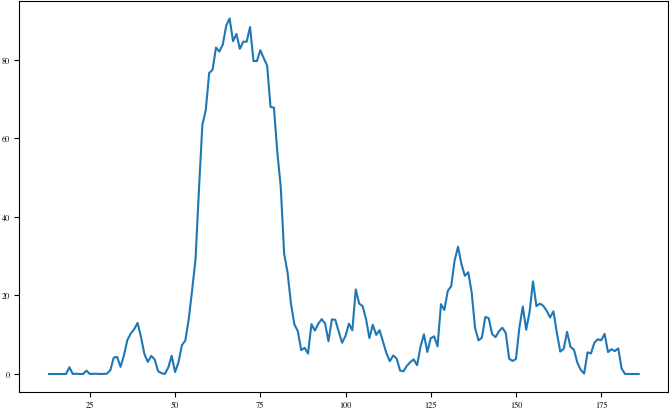

In [1754]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.plot(d1FirstLastCumSumPeopleMonday['queue_mean_count'])

In [ ]:
dQeue = queue_model_uncertaintySP_PC(3, 5, 2, d1TimeFirstLastCumSumPeopleMonday)

plt.plot(dQeue['frame.time'], dQeue['queue_count'].to_numpy(), label='Queue')
plt.plot(d1FirstLastCumSumPeopleMonday['frame.time'], d1FirstLastCumSumPeopleMonday['count_CumSum'], label='Total count')
plt.plot(d1FirstLastCumSumPeopleMonday['frame.time'], d1FirstLastCumSumPeopleMonday['count_First'], label='First seen count')
plt.title(title)
plt.ylabel('unique macs / min')
plt.xlabel('time')
locsy, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.linspace(min(locsy), max(locsy), num=9))
plt.xticks(locs[::ticks])
plt.grid(True)
plt.legend()
plt.show()

In [1837]:
d1QueuePeopleMonday = d1FirstLastCumSumQueuePeopleMonday[['frame.time', 'queue_mean_count']]

In [1844]:
# Assuming df is your DataFrame and 'time' is your time column
df_melted = pd.melt(d5QueueWeek, id_vars='frame.time', var_name='day', value_name='Count')


In [1848]:
d5QueueWeek

,frame.time,count_First_Monday,count_Last_Monday,count_CumSum_Monday,count_CumSum_people_mean_Monday,count_CumSum_people_stderr_Monday,count_Last_people_mean_Monday,count_Last_people_stderr_Monday,count_First_people_mean_Monday,count_First_people_stderr_Monday,...,count_CumSum_Friday,count_CumSum_people_mean_Friday,count_CumSum_people_stderr_Friday,count_Last_people_mean_Friday,count_Last_people_stderr_Friday,count_First_people_mean_Friday,count_First_people_stderr_Friday,queue_count_Friday,queue_mean_count_Friday,queue_stderr_count_Friday


In [1845]:
df_melted

,frame.time,day,Count


## Count

### First Seen

In [1766]:
d5Week = rename_merge([d5TimeFirstLastCumSumPeopleMonday, d5TimeFirstLastCumSumPeopleTuesday, d5TimeFirstLastCumSumPeopleWednesday, d5TimeFirstLastCumSumPeopleThursday, d5TimeFirstLastCumSumPeopleFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

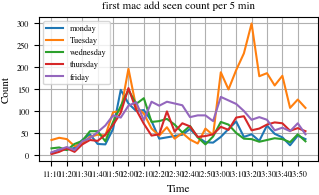

In [1697]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plt.plot(d5Week['frame.time'], d5Week['count_First_Monday'], label='monday')
plt.plot(d5Week['frame.time'], d5Week['count_First_Tuesday'], label='Tuesday')
plt.plot(d5Week['frame.time'], d5Week['count_First_Wednesday'], label='wednesday')
plt.plot(d5Week['frame.time'], d5Week['count_First_Thursday'], label='thursday')
plt.plot(d5Week['frame.time'], d5Week['count_First_Friday'], label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('first mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])


plt.savefig('./plots/first_seen_mac_per_5_min.pdf')

### Last Seen

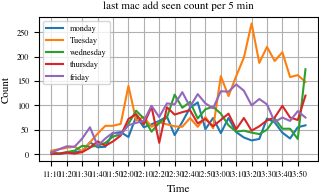

In [1698]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plt.plot(d5Week['frame.time'], d5Week['count_Last_Monday'], label='monday')
plt.plot(d5Week['frame.time'], d5Week['count_Last_Tuesday'], label='Tuesday')
plt.plot(d5Week['frame.time'], d5Week['count_Last_Wednesday'], label='wednesday')
plt.plot(d5Week['frame.time'], d5Week['count_Last_Thursday'], label='thursday')
plt.plot(d5Week['frame.time'], d5Week['count_Last_Friday'], label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.title('last mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])


plt.savefig('./plots/last_seen_mac_per_5_min.pdf')

### First, Last & Cumaltive Sum

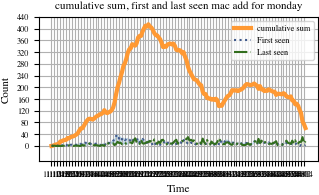

In [1755]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.title('cumulative sum, first and last seen mac add for monday')
plt.xlabel('Time')
plt.ylabel('Count')

plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_CumSum'], color = rgb.pn_orange, label='cumulative sum', linewidth=3)
plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], color = rgb.tue_darkblue, label='First seen', linestyle= ':')
plt.plot(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_Last'], color = rgb.tue_darkgreen, label='Last seen', linestyle= '-.')

plt.fill_between(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], d5TimeFirstLastCumSumMonday['count_Last'], where=(d5TimeFirstLastCumSumMonday['count_First'] > d5TimeFirstLastCumSumMonday['count_Last']), interpolate=True, color = rgb.tue_blue, alpha = 0.2)
plt.fill_between(d5TimeFirstLastCumSumMonday['frame.time'], d5TimeFirstLastCumSumMonday['count_First'], d5TimeFirstLastCumSumMonday['count_Last'], where=(d5TimeFirstLastCumSumMonday['count_First'] <= d5TimeFirstLastCumSumMonday['count_Last']), interpolate=True, color = rgb.tue_green, alpha = 0.2)
# plt.fill_between(d5MondayCumFirstLast['frame.time'], d5MondayCumFirstLast['count_CumSum'], color = rgb.tue_blue, alpha = 0.2)

plt.legend()
# plt.legend(fontsize='large')
plt.grid(True)

locsy, labels = plt.yticks()
locs, labels = plt.xticks()
plt.yticks(np.arange(0, max(locsy) + 1, 40))
plt.xticks(locs[::2])

# plt.xlim([xmin, xmax])
plt.ylim([-50, 440])

plt.savefig('./plots/CumSumFirstLastMonday.pdf')

### Cumaltative Sum of all days

In [1758]:
d5Week['count_CumSum_Friday'].min()

-6.0

In [1809]:
d5Week

,frame.time,count_First_Monday,count_Last_Monday,count_CumSum_Monday,count_CumSum_people_mean_Monday,count_CumSum_people_stderr_Monday,count_Last_people_mean_Monday,count_Last_people_stderr_Monday,count_First_people_mean_Monday,count_First_people_stderr_Monday,...,count_First_people_stderr_Thursday,count_First_Friday,count_Last_Friday,count_CumSum_Friday,count_CumSum_people_mean_Friday,count_CumSum_people_stderr_Friday,count_Last_people_mean_Friday,count_Last_people_stderr_Friday,count_First_people_mean_Friday,count_First_people_stderr_Friday
0,11:12,1.0,1.0,0.0,0.000,0.000000,0.950,0.028517,0.944,0.027633,...,0.000000,1,1.0,15.0,14.249,0.107689,0.946,0.027750,0.970,0.029222
1,11:13,1.0,0.0,1.0,0.945,0.028765,0.000,0.000000,0.935,0.030397,...,0.028503,0,1.0,14.0,13.299,0.100146,0.961,0.027216,0.000,0.000000
2,11:14,3.0,1.0,3.0,2.824,0.052469,0.949,0.029204,2.846,0.049613,...,0.000000,0,0.0,14.0,13.242,0.102007,0.000,0.000000,0.000,0.000000
3,11:15,2.0,0.0,5.0,4.791,0.061650,0.000,0.000000,1.898,0.039508,...,0.029158,1,2.0,13.0,12.316,0.102588,1.901,0.039711,0.945,0.028393
4,11:16,1.0,0.0,6.0,5.686,0.071976,0.000,0.000000,0.961,0.029113,...,0.029108,4,1.0,16.0,15.191,0.110603,0.962,0.026934,3.814,0.054696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,13:55,10.0,7.0,169.0,160.356,0.381416,6.743,0.076299,9.492,0.090208,...,0.128869,5,11.0,124.0,117.716,0.311921,10.420,0.094664,4.800,0.062244
164,13:56,4.0,18.0,155.0,147.183,0.356737,16.992,0.122848,3.798,0.059364,...,0.073572,8,13.0,119.0,113.135,0.295913,12.332,0.095714,7.614,0.079231
165,13:57,8.0,9.0,154.0,146.368,0.352174,8.540,0.088422,7.546,0.080369,...,0.071469,12,17.0,114.0,108.279,0.294462,16.162,0.113713,11.375,0.095347
166,13:58,7.0,19.0,142.0,134.913,0.341375,18.017,0.130047,6.649,0.080722,...,0.088987,18,20.0,112.0,106.091,0.298221,19.024,0.121324,17.068,0.113335


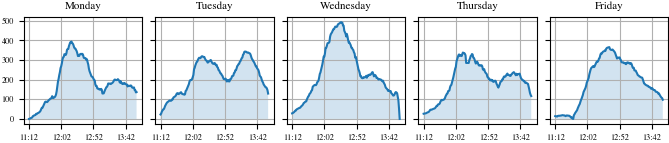

In [1822]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
plt.rcParams.update(figsizes.icml2022_full(nrows=1, ncols=5, height_to_width_ratio = 1.1))

fig, axs = plt.subplots(nrows = 1, ncols = 5, sharey=True)  # Create 5 subplots in one row, sharing the same y-axis
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()

# Adjust the space between subplots
plt.subplots_adjust(wspace=5.0)  # Adjust the space between subplots horizontally

# Remove the box (spines) around the plot
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

axs[0].plot(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Monday'])
axs[1].plot(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Tuesday'])
axs[2].plot(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Wednesday'])
axs[3].plot(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Thursday'])
axs[4].plot(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Friday'])

axs[0].fill_between(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Monday'], alpha=0.2)
axs[1].fill_between(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Tuesday'], alpha=0.2)
axs[2].fill_between(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Wednesday'], alpha=0.2)
axs[3].fill_between(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Thursday'], alpha=0.2)
axs[4].fill_between(d5Week['frame.time'], d5Week['count_CumSum_people_mean_Friday'], alpha=0.2)

titles = ['Monday','Tuesday','Wednesday','Thursday','Friday']

# FiXME time ticks 
for i, ax in enumerate(axs):
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.grid(True)
    ax.set_title(titles[i])  # Add a title to each subplot
    

plt.savefig('./plots/cumSumWeek.pdf')
plt.show()

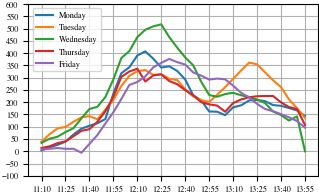

In [1557]:
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Monday'], label='Monday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Tuesday'], label='Tuesday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Wednesday'], label='Wednesday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Thursday'], label='Thursday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Friday'], label='Friday')
locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=15))
plt.xticks(locsx[::3])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()


### Cumualtive Sum of all days in joyplots

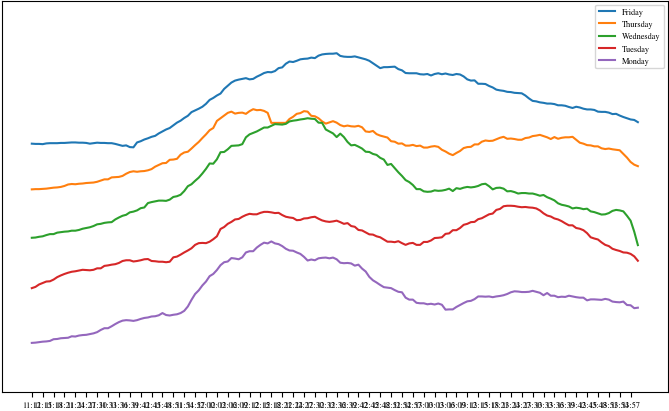

In [1834]:
x = np.arange(0.0, len(d5Week['count_CumSum_Monday']), 1)

plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Friday'] + 800, label='Friday', zorder=2)
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Thursday'] + 600, label='Thursday', zorder=4)
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Wednesday'] + 400, label='Wednesday', zorder=6)
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Tuesday'] + 200, label='Tuesday', zorder=8)
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Monday'], label='Monday', zorder=10)

plt.fill_between(d5Week['frame.time'], d5Week['count_CumSum_Friday'] + 800, color='white', zorder=1)
plt.fill_between(d5Week['frame.time'], d5Week['count_CumSum_Thursday']+ 600 , color='white', zorder=3)
plt.fill_between(d5Week['frame.time'], d5Week['count_CumSum_Wednesday'] + 400, color='white', zorder=5)
plt.fill_between(d5Week['frame.time'], d5Week['count_CumSum_Tuesday'] + 200, color='white', zorder=7)
plt.fill_between(d5Week['frame.time'], d5Week['count_CumSum_Monday'], color='white', zorder=9)

plt.gca().yaxis.set_visible(False) 

locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=10))
plt.xticks(locsx[::3])
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()

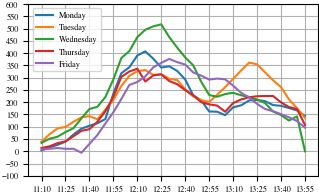

In [1559]:
x = np.arange(0.0, len(d5Week['count_CumSum_Monday']), 1)

plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Monday'], label='Monday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Tuesday'] , label='Tuesday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Wednesday'], label='Wednesday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Thursday'] , label='Thursday')
plt.plot(d5Week['frame.time'],d5Week['count_CumSum_Friday'], label='Friday')

locsy, labels = plt.yticks()
locsx, labels = plt.xticks()
plt.legend()
plt.yticks(np.linspace(min(locsy), max(locsy), num=15))
plt.xticks(locsx[::3])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()

In [1560]:
d5Week.columns

Index(['frame.time', 'count_First_Monday', 'count_Last_Monday',
       'count_CumSum_Monday', 'count_First_Tuesday', 'count_Last_Tuesday',
       'count_CumSum_Tuesday', 'count_First_Wednesday', 'count_Last_Wednesday',
       'count_CumSum_Wednesday', 'count_First_Thursday', 'count_Last_Thursday',
       'count_CumSum_Thursday', 'count_First_Friday', 'count_Last_Friday',
       'count_CumSum_Friday'],
      dtype='object')

In [1416]:
d5CumSumWeek = d5Week[['frame.time','count_CumSum_Monday','count_CumSum_Tuesday', 'count_CumSum_Wednesday','count_CumSum_Thursday','count_CumSum_Friday']]
# Assuming d5Week is a DataFrame with columns representing days of the week

labels = d5CumSumWeek['frame.time'].astype(str).drop_duplicates().sort_index()
x_range = list(range(len(labels) + 1))
fig, axes = joypy.joyplot(d5CumSumWeek, column="frame.time", kind="values")

plt.show()

ValueError: No numeric values found. Joyplot requires at least a numeric column/group.

In [1380]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
x_range = list(range(39))
labels = d5WeekSplit['time'].astype(str).drop_duplicates().sort_index()

# Change the x-axis labels
fig, axes = joypy.joyplot(d5WeekSplit, column='count', by='date', kind="values", x_range = x_range, overlap=1, linewidth=0.6)
axes[-1].set_xticklabels(labels[::6])
plt.savefig('./plots/cumSumWeekJoy.pdf')
plt.show()

KeyError: 'time'